In [2]:
# Import SQLAlchemy and other dependencies 
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func
import datetime as dt
import pandas as pd
import matplotlib
from matplotlib import style
style.use('seaborn')
import matplotlib.pyplot as plt
from sqlalchemy import Column, Integer, String, Float, Text, ForeignKey
import numpy as np

In [3]:
# Create engine using the `hawaii.sqlite` database file created in database_engineering steps
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [4]:
# Declare a Base using `automap_base()`
Base = automap_base()

In [5]:
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['measurement', 'station']

In [7]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
inspector.get_table_names()

['measurement', 'station']

In [8]:
# Use `engine.execute` to select and display the first 10 rows from the table

engine.execute('SELECT * FROM measurement LIMIT 10').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0),
 (6, 'USC00519397', '2010-01-07', 0.06, 70.0),
 (7, 'USC00519397', '2010-01-08', 0.0, 64.0),
 (8, 'USC00519397', '2010-01-09', 0.0, 68.0),
 (9, 'USC00519397', '2010-01-10', 0.0, 73.0),
 (10, 'USC00519397', '2010-01-11', 0.01, 64.0)]

In [9]:
# Reflect Database into ORM class
Station = Base.classes.station
Measurements = Base.classes.measurement

In [10]:
# Start a session to query the database
session = Session(engine)

In [11]:
# Grabs the last date entry in the data table
last_date = session.query(Measurements.date).order_by(Measurements.date.desc()).first()
print(last_date)

('2017-08-23',)


In [12]:
# to get the last 12 months of data, last date - 365
last_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)
print(last_year)

2016-08-23


In [13]:
# query to pull the last year of precipitation data
rain = session.query(Measurements.date, Measurements.prcp).\
    filter(Measurements.date > last_year).\
    order_by(Measurements.date).all()

In [14]:
# Load the data from the query into a dataframe
rain_df = pd.DataFrame(rain)
rain_df.head()

,date,prcp
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [15]:
# reset the index to the date
rain_df.set_index('date').head()

,prcp
date,
2016-08-24,0.08
2016-08-24,2.15
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


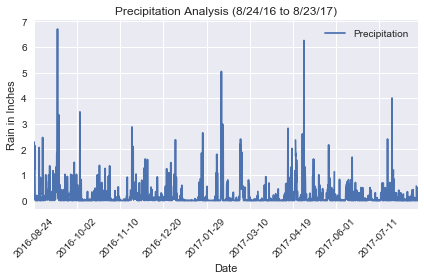

In [16]:
# plot the dataframe
rain_df.plot('date', 'prcp')
plt.xlabel("Date")
plt.ylabel("Rain in Inches")
plt.title("Precipitation Analysis (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [17]:
# Use Pandas to print the summary statistics for the precipitation data.
rain_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Count the number of stations in the Measurement table
locations = session.query(Measurements).group_by(Measurements.station).count()
print("There are {} stations.".format(locations))

There are 9 stations.


In [19]:
# find the station with the most temperature observations, then list them all in descending order
busy_station = session.query(Measurements.station, func.count(Measurements.tobs)).group_by(Measurements.station).\
               order_by(func.count(Measurements.tobs).desc()).all()

busiest = busy_station[0][0]    
print("The busiest Station was",busiest,"with",busy_station[0][1],"weather observations.")
print()
print("Here are all of the Stations (in descending order) with their number of observations:")
for station, count in busy_station:
    print("Station",station,"had",count, "weather observations.")

The busiest Station was USC00519281 with 2772 weather observations.

Here are all of the Stations (in descending order) with their number of observations:
Station USC00519281 had 2772 weather observations.
Station USC00519397 had 2724 weather observations.
Station USC00513117 had 2709 weather observations.
Station USC00519523 had 2669 weather observations.
Station USC00516128 had 2612 weather observations.
Station USC00514830 had 2202 weather observations.
Station USC00511918 had 1979 weather observations.
Station USC00517948 had 1372 weather observations.
Station USC00518838 had 511 weather observations.


In [20]:
# query to pull the last year of precipitation data for the busiest station
temperature = session.query(Measurements.station, Measurements.date, Measurements.tobs).\
    filter(Measurements.station == busiest).\
    filter(Measurements.date > last_year).\
    order_by(Measurements.date).all()

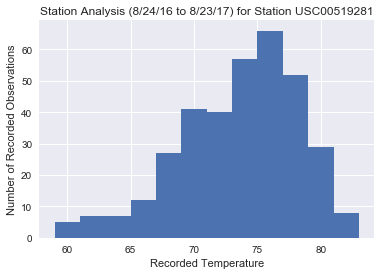

In [21]:
# plot the temperature data in a histogram with 12 bins
temp_df=pd.DataFrame(temperature)
plt.hist(temp_df['tobs'],12)
plt.xlabel("Recorded Temperature")
plt.ylabel("Number of Recorded Observations")
plt.title("Station Analysis (8/24/16 to 8/23/17) for Station " + busiest)
plt.show()

In [22]:
Temp=[]
start_date='2016-08-01'
end_date='2017-08-01'
def calc_temps(start_date, end_date):
    results=session.query(func.max(Measurements.tobs).label("max_tobs"), \
                          func.min(Measurements.tobs).label("min_tobs"),\
                          func.avg(Measurements.tobs).label("avg_tobs")).\
                          filter(Measurements.date.between(start_date , end_date))  
    res = results.one()
    res
    TMAX = res.max_tobs
    TMIN= res.min_tobs
    TAVG= res.avg_tobs
    Temp.append(TMAX)
    Temp.append(TMIN)
    Temp.append(TAVG)
    #print(str(TMAX))
    #print(str(TMIN))
    #print(str(TAVG))
calc_temps(start_date, end_date)
Temp

[87.0, 58.0, 74.64288840262581]

In [23]:
TAVG=Temp[2]
TMIN=Temp[1]
TMAX=Temp[0]

C:\Users\btech\Anaconda3\envs\PythonData\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


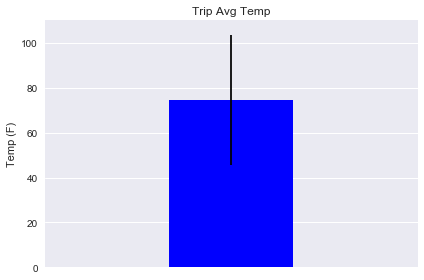

In [24]:
plt.bar( 1,TAVG, color = 'blue', yerr = TMAX-TMIN, align='center')
plt.xlim(-0.2, 2.2)
plt.ylim([0, 110])
plt.axes().get_xaxis().set_visible(False)
plt.title('Trip Avg Temp')
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.show()

In [41]:
Rainfall_results = session.query(Measurements.station, func.count(Measurements.prcp)).\
                   group_by(Measurements.station).filter(Measurements.date.between('2016-08-01', '2017-08-01')).all()
Rainfall_results

[('USC00513117', 365),
 ('USC00514830', 261),
 ('USC00516128', 331),
 ('USC00517948', 67),
 ('USC00519281', 365),
 ('USC00519397', 361),
 ('USC00519523', 320)]

In [42]:
for i in range(1,16):
    print(i)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [44]:
from sqlalchemy import extract  
trip_month=8
trip_days=range(1, 16)
for i in range(1, 16):
    subquery=session.query(Measurements.date).filter(extract('month', Measurements.date)==trip_month).\
             filter(extract('day', Measurements.date)== i ).group_by(Measurements.date).order_by(Measurements.date).all()
subquery

[('2010-08-15'),
 ('2011-08-15'),
 ('2012-08-15'),
 ('2013-08-15'),
 ('2014-08-15'),
 ('2015-08-15'),
 ('2016-08-15'),
 ('2017-08-15')]

In [45]:
dates=[]
daily_normals_Three_AVG=[]
daily_normals_TMAX=[]
daily_normals_TMIN=[]
daily_normals_TAVG=[]

trip_month=8
trip_days=range(1, 16)

def daily_normals():
    
    for i in range(1,16):
        results=session.query(Measurements.date.label("dates"), func.max(Measurements.tobs).label("max_tobs"),\
                             func.min(Measurements.tobs).label("min_tobs"),func.avg(Measurements.tobs).label("avg_tobs")).\
                             filter(extract('month', Measurements.date)==trip_month).\
                             filter(extract('day', Measurements.date)== i ).group_by(Measurements.date).order_by(Measurements.date)
        results
        for res in results.all():
             print( res)
        
        res
        TMAX = res.max_tobs
        TMIN= res.min_tobs
        TAVG= res.avg_tobs
        Date= res.dates
        
        data = [TMAX, TMIN, TAVG]
        #avg = [float(sum(col))/len(col) for col in zip(*data)]

        dates.append(Date)
        #daily_normals_Three_AVG.append(avg)
        daily_normals_TMAX.append(TMAX)
        daily_normals_TMIN.append(TMIN)
        daily_normals_TAVG.append(TAVG)
        
daily_normals()

('2010-08-01', 77.0, 71.0, 73.42857142857143)
('2011-08-01', 78.0, 67.0, 73.375)
('2012-08-01', 79.0, 71.0, 75.85714285714286)
('2013-08-01', 79.0, 75.0, 76.83333333333333)
('2014-08-01', 83.0, 73.0, 77.42857142857143)
('2015-08-01', 79.0, 73.0, 77.4)
('2016-08-01', 78.0, 73.0, 76.16666666666667)
('2017-08-01', 77.0, 72.0, 74.5)
('2010-08-02', 76.0, 70.0, 73.22222222222223)
('2011-08-02', 77.0, 70.0, 73.625)
('2012-08-02', 78.0, 68.0, 73.5)
('2013-08-02', 78.0, 70.0, 74.57142857142857)
('2014-08-02', 81.0, 73.0, 77.71428571428571)
('2015-08-02', 84.0, 76.0, 80.0)
('2016-08-02', 80.0, 72.0, 76.57142857142857)
('2017-08-02', 83.0, 73.0, 79.0)
('2010-08-03', 77.0, 70.0, 73.11111111111111)
('2011-08-03', 78.0, 71.0, 75.25)
('2012-08-03', 78.0, 72.0, 74.57142857142857)
('2013-08-03', 79.0, 72.0, 76.66666666666667)
('2014-08-03', 83.0, 74.0, 78.33333333333333)
('2015-08-03', 85.0, 75.0, 80.0)
('2016-08-03', 82.0, 74.0, 78.42857142857143)
('2017-08-03', 81.0, 76.0, 79.0)
('2010-08-04', 77.0, 

In [46]:
Daily_normals_df= pd.DataFrame({'Date': dates, 'TMAX': daily_normals_TMAX, 'TMIN': daily_normals_TMIN,'TAVG': daily_normals_TAVG,})
Daily_normals_df.set_index('Date', inplace=True, )
Daily_normals_df.head()

,TMAX,TMIN,TAVG
Date,,,
2017-08-01,77.0,72.0,74.5
2017-08-02,83.0,73.0,79.0
2017-08-03,81.0,76.0,79.0
2017-08-04,82.0,77.0,80.0
2017-08-05,82.0,77.0,80.0


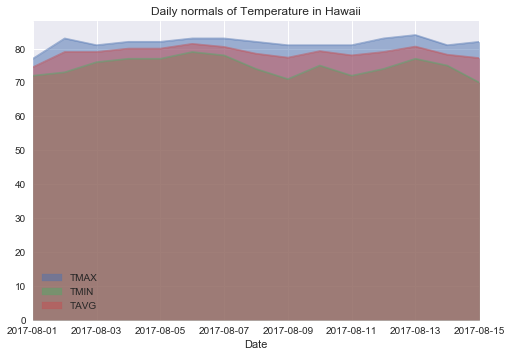

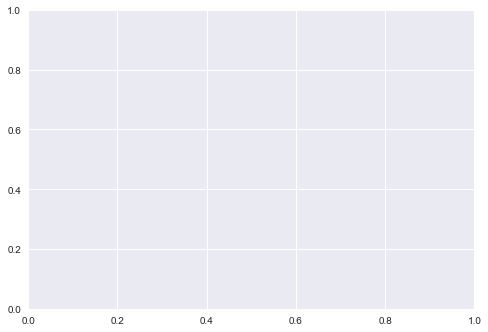

In [50]:
Daily_normals_df.plot.area(stacked=False, title='Daily normals of Temperature in Hawaii')
ax = plt.subplots()
plt.show()